# Analisi Game Experience Questionnaire (GEQ)

Questo notebook analizza i dati raccolti mediante il Game Experience Questionnaire (GEQ), calcolando i punteggi delle varie componenti secondo le linee guida ufficiali e creando visualizzazioni utili per l'inclusione nella tesi.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from math import pi

# Configurazione del notebook
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Definizione delle Componenti GEQ

Secondo le linee guida ufficiali, il GEQ è suddiviso in diverse componenti per ogni modulo. Qui sotto definiamo quali domande appartengono a ciascuna componente.

In [25]:
# Definizione delle componenti di ogni modulo
GEQ_COMPONENTS = {
    # Core Module
    'Core Module': {
        'Competenza': [2, 10, 15, 17, 21],
        'Immersione Sensoriale e Immaginativa': [3, 12, 18, 19, 27, 30],
        'Flusso': [5, 13, 25, 28, 31],
        'Tensione/Fastidio': [22, 24, 29],
        'Sfida': [11, 23, 26, 32, 33],
        'Affetto Negativo': [7, 8, 9, 16],
        'Affetto Positivo': [1, 4, 6, 14, 20]
    },
    # In-Game Module
    'In-game Module': {
        'Competenza': [35, 42],
        'Immersione Sensoriale e Immaginativa': [34, 37],
        'Flusso': [38, 43],
        'Tensione': [39, 41],
        'Sfida': [45, 46],
        'Affetto Negativo': [36, 40],
        'Affetto Positivo': [44, 47]
    },
    # Post-Game Module
    'Post-game Module': {
        'Esperienza Positiva': [48, 52, 54, 55, 59, 63],
        'Esperienza Negativa': [49, 51, 53, 58, 61, 62],
        'Stanchezza': [57, 60],
        'Ritorno alla Realtà': [50, 56, 64]
    }
}

## Caricamento dei Dati

Per prima cosa, carichiamo il file CSV dei risultati del GEQ per analizzarlo.

In [22]:
# Modifica il percorso al tuo file CSV
data_path = "./results_1.csv"

# Carica i dati
df = pd.read_csv(data_path)

# Visualizza le prime righe per controllare
df.head()

,player_id,timestamp,session_type,module_name,question_id,question_text,response
0,1SV4NK,2025-03-05T16:10:37.142Z,in_game,In-game Module,34,Mi interessava la storia del gioco,0
1,1SV4NK,2025-03-05T16:10:37.142Z,in_game,In-game Module,35,Mi sono sentito/a soddisfatto/a,1
2,1SV4NK,2025-03-05T16:10:37.142Z,in_game,In-game Module,36,Mi sono annoiato/a,2
3,1SV4NK,2025-03-05T16:10:37.142Z,in_game,In-game Module,37,L'ho trovato impressionante,2
4,1SV4NK,2025-03-05T16:10:37.142Z,in_game,In-game Module,38,Ho dimenticato tutto ciò che mi circondava,1


In [23]:
# Controlla quanti partecipanti e risposte abbiamo
print(f"Numero totale di risposte: {len(df)}")
print(f"Numero di partecipanti unici: {df['player_id'].nunique() / 2}")

Numero totale di risposte: 64
Numero di partecipanti unici: 1.0


## Calcolo dei Punteggi delle Componenti

Ora calcoleremo i punteggi medi per ogni componente di ogni modulo, per ogni partecipante.

In [27]:
# Calcola la media delle componenti per ogni modulo
results = {}

# Per ogni modulo
for module_name, componentsResults in GEQ_COMPONENTS.items():
    module_data = df[df['module_name'] == module_name]
    
    if not module_data.empty:
        results[module_name] = {}
        
        # Per ogni componente in questo modulo
        for component_name, question_ids in componentsResults.items():
            # Filtra le risposte per questa componente
            component_data = module_data[module_data['question_id'].isin(question_ids)]
            
            if not component_data.empty:
                # Calcola la media
                avg_score = component_data['response'].mean()
                results[module_name][component_name] = avg_score

# Mostra i risultati
print("\nRisultati per ogni componente:")
for module_name, componentsResults in results.items():
    print(f"\n{module_name}:")
    for component_name, score in componentsResults.items():
        print(f"  {component_name}: {score:.2f}")


Risultati per ogni componente:

Core Module:
  Competenza: 2.00
  Immersione Sensoriale e Immaginativa: 2.00
  Flusso: 2.20
  Tensione/Fastidio: 2.00
  Sfida: 2.40
  Affetto Negativo: 2.25
  Affetto Positivo: 1.80

In-game Module:
  Competenza: 2.50
  Immersione Sensoriale e Immaginativa: 1.00
  Flusso: 2.00
  Tensione: 2.50
  Sfida: 3.50
  Affetto Negativo: 2.00
  Affetto Positivo: 2.50

Post-game Module:
  Esperienza Positiva: 1.17
  Esperienza Negativa: 1.17
  Stanchezza: 0.50
  Ritorno alla Realtà: 1.67


## Visualizzazioni dei Risultati

Ora creiamo alcune visualizzazioni dei risultati per aiutare l'interpretazione.

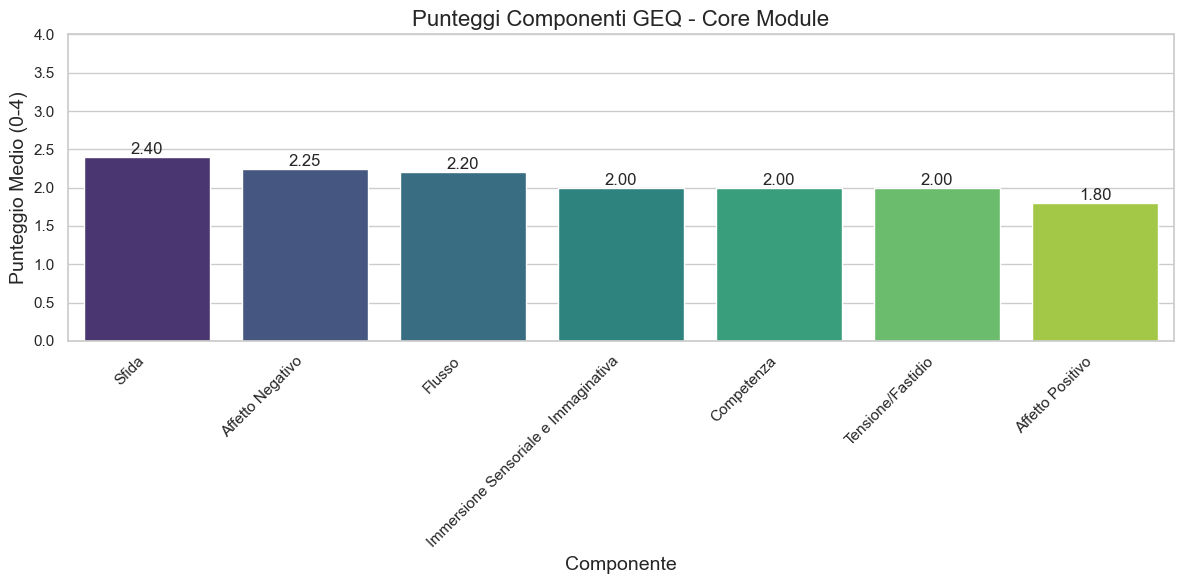

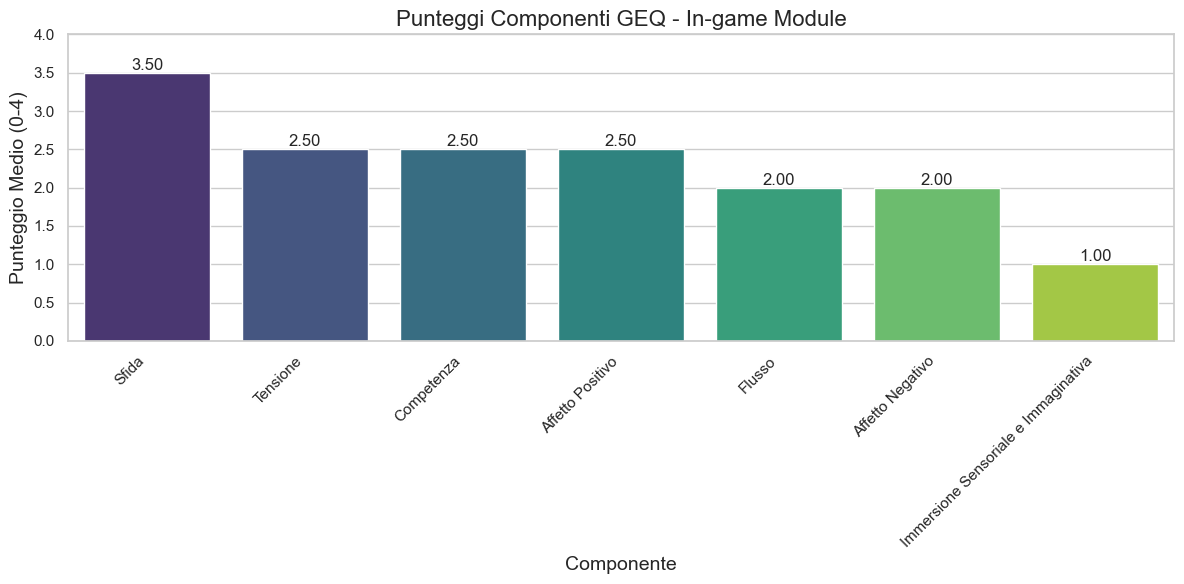

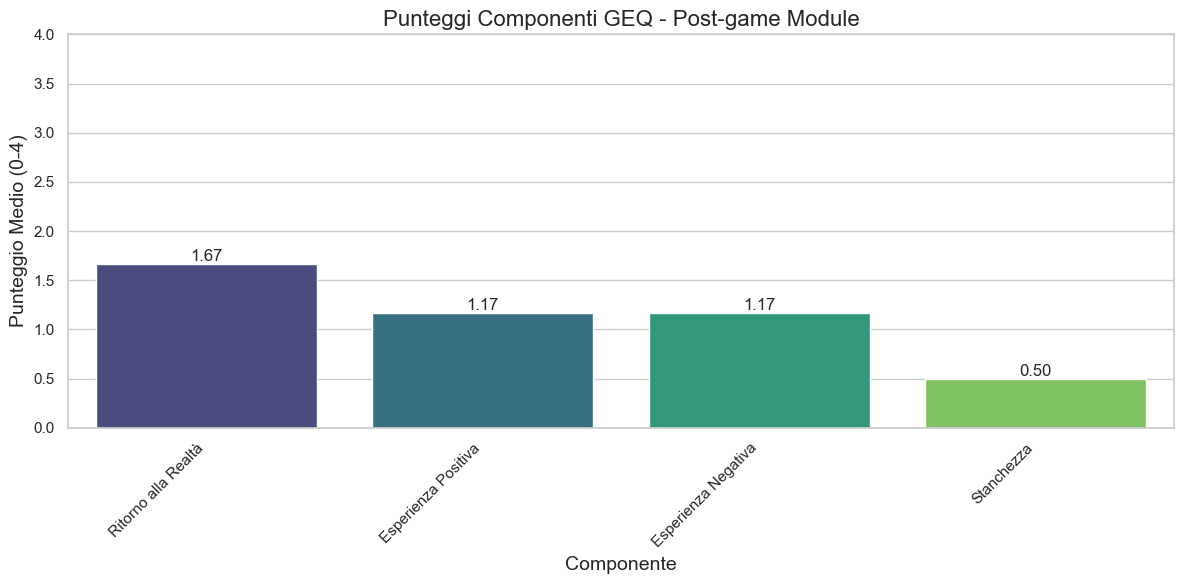

In [30]:
# Per ogni modulo, crea un grafico a barre
for module_name, componentsResults in results.items():
    if componentsResults:
        # Converti in DataFrame per il grafico
        df_plot = pd.DataFrame(list(componentsResults.items()), columns=['Componente', 'Punteggio'])
        
        # Ordina per punteggio
        df_plot = df_plot.sort_values('Punteggio', ascending=False)
        
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Componente', y='Punteggio', data=df_plot, palette='viridis', hue='Componente', legend=False)
        
        plt.title(f'Punteggi Componenti GEQ - {module_name}', fontsize=16)
        plt.xlabel('Componente', fontsize=14)
        plt.ylabel('Punteggio Medio (0-4)', fontsize=14)
        plt.ylim(0, 4)
        
        # Ruota le etichette
        plt.xticks(rotation=45, ha='right')
        
        # Aggiungi valori sopra le barre
        for i, p in enumerate(ax.patches):
            ax.annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=12, rotation=0)
        
        plt.tight_layout()
        plt.show()

## Grafico Radar delle Componenti del Core Module

Un grafico radar può essere utile per visualizzare il profilo complessivo dell'esperienza di gioco.

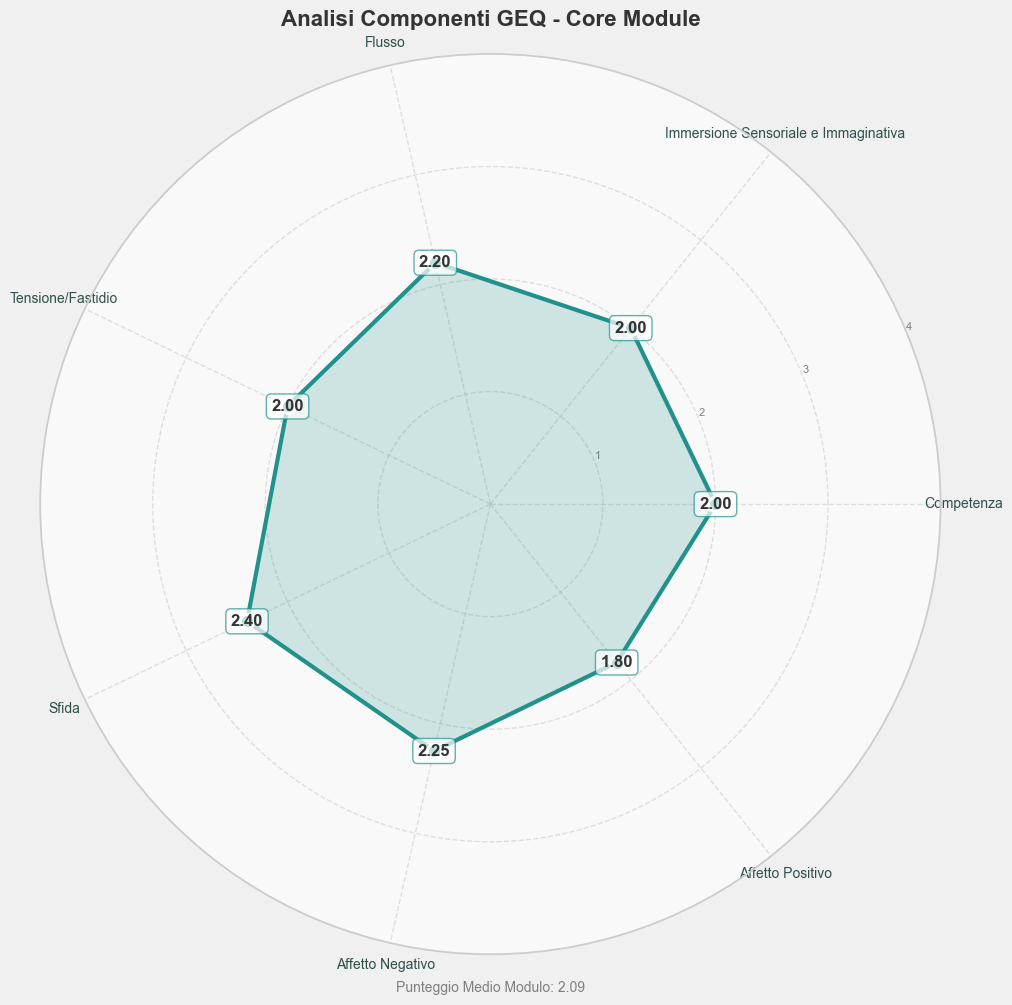

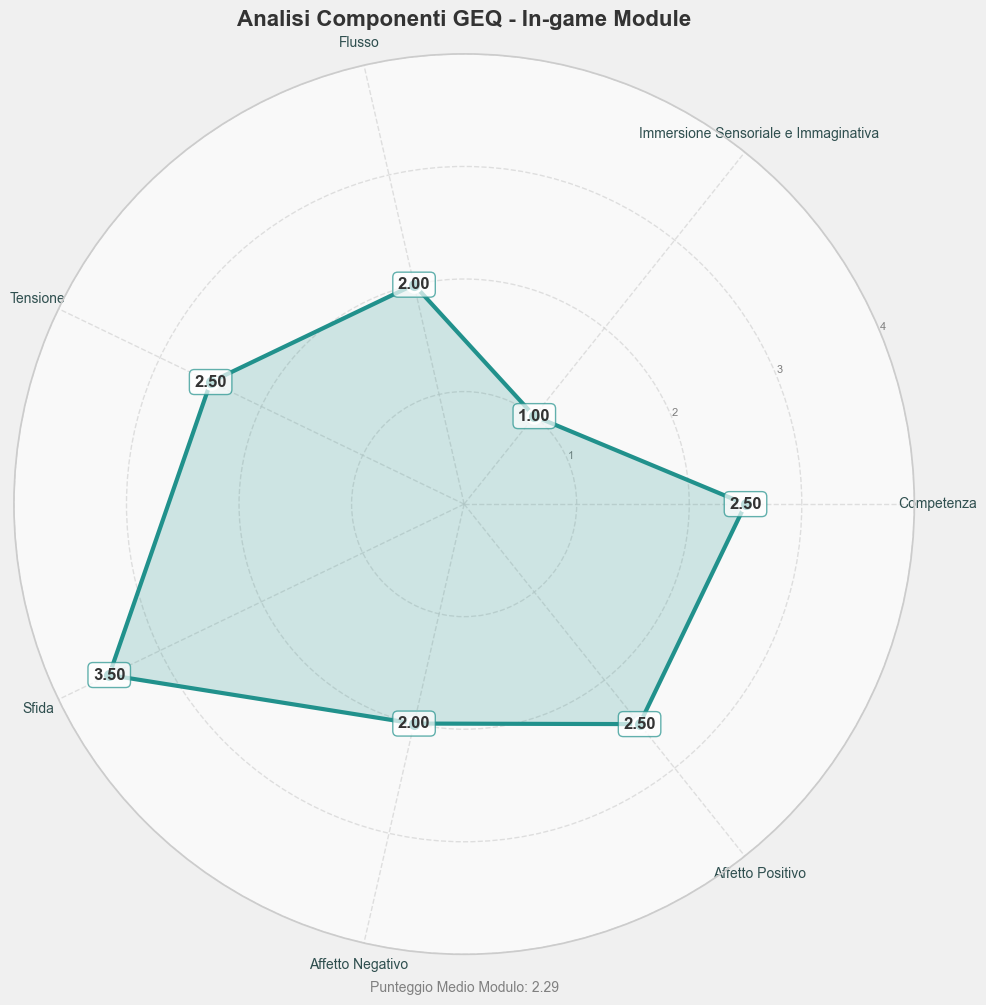

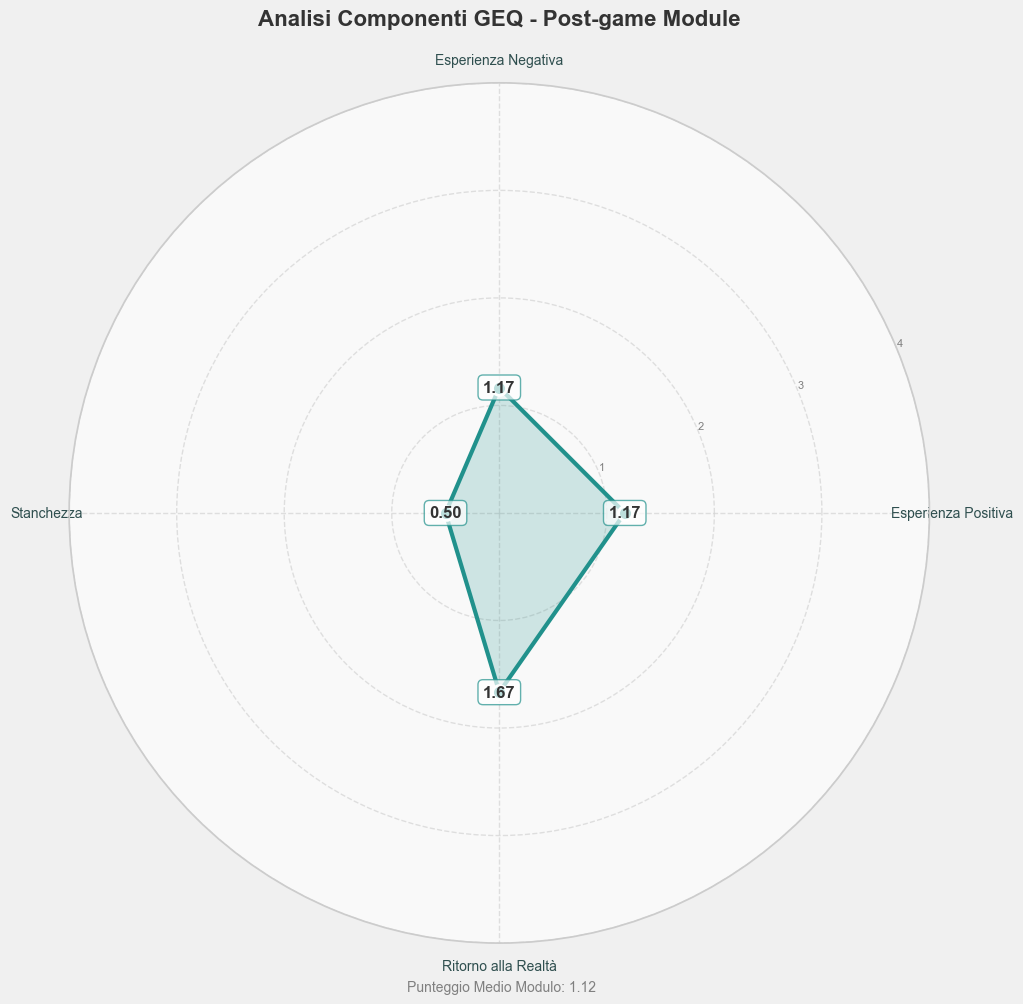

In [38]:
def create_advanced_radar_chart(results, module_name):
    """
    Crea un grafico radar avanzato e visivamente accattivante.
    
    Args:
        results (dict): Dizionario dei risultati per componente
        module_name (str): Nome del modulo
    """
    # Preparazione dei dati
    components = list(results.keys())
    scores = list(results.values())
    
    # Numero di componenti
    num_components = len(components)
    
    # Calcolo degli angoli
    angles = [n / float(num_components) * 2 * np.pi for n in range(num_components)]
    
    # Chiudi il poligono
    scores += scores[:1]
    angles += angles[:1]
    
    # Configurazione del grafico con stile moderno
    plt.figure(figsize=(12, 10), facecolor='#f0f0f0')
    ax = plt.subplot(111, polar=True)
    
    # Imposta lo sfondo
    ax.set_facecolor('#f9f9f9')
    
    # Aggiungi griglie radiali personalizzate
    ax.set_rlim(0, 4)
    ax.set_rticks([1, 2, 3, 4])
    ax.set_yticklabels(['1', '2', '3', '4'], color='gray', size=8)
    ax.grid(color='lightgray', linestyle='--', alpha=0.7)
    
    # Colore della palette
    color = sns.color_palette("viridis", n_colors=1)[0]
    
    # Disegna il poligono con stile
    ax.plot(angles, scores, color=color, linewidth=3, 
            marker='o', markersize=10, 
            markerfacecolor=color, 
            markeredgecolor='white', 
            markeredgewidth=2)
    
    # Riempimento con trasparenza
    ax.fill(angles, scores, color=color, alpha=0.2)
    
    # Personalizzazione delle etichette
    plt.xticks(angles[:-1], components, color='darkslategray', size=10)
    
    # Titolo con stile
    plt.title(f'Analisi Componenti GEQ - {module_name}', 
              fontsize=16, 
              fontweight='bold', 
              color='#333333', 
              pad=20)
    
    # Aggiungi valori con ombreggiatura
    for angle, score, component in zip(angles[:-1], scores[:-1], components):
        ax.text(angle, score, f'{score:.2f}', 
                color='#333333', 
                fontweight='bold',
                horizontalalignment='center', 
                verticalalignment='center', 
                bbox=dict(facecolor='white', 
                          edgecolor=color, 
                          boxstyle='round,pad=0.3', 
                          alpha=0.7))
    
    # Annotazione con statistiche
    mean_score = np.mean(scores[:-1])
    plt.figtext(0.5, 0, 
                f'Punteggio Medio Modulo: {mean_score:.2f}', 
                ha='center', 
                fontsize=10, 
                color='gray')
    
    plt.tight_layout()
    plt.show()

# Funzione per generare grafici radar per tutti i moduli
def generate_radar_charts(results):
    """
    Genera grafici radar per tutti i moduli.
    
    Args:
        results (dict): Dizionario dei risultati per ogni modulo
    """
    for module_name, module_results in results.items():
        create_advanced_radar_chart(module_results, module_name)

# Chiamata nel tuo script principale
generate_radar_charts(results)